# Introduction to Data Science 2025

# Week 6: Recap

## Exercise 1 | Linear regression with feature selection

Download the [TED Talks](https://www.kaggle.com/rounakbanik/ted-talks) dataset from Kaggle. Your task is to predict both the ratings and the number of views of a given TED talk. You should focus only on the <span style="font-weight: bold">ted_main</span> table.

1. Download the data, extract the following ratings from column <span style="font-weight: bold">ratings</span>: <span style="font-weight: bold">Funny</span>, <span style="font-weight: bold">Confusing</span>, <span style="font-weight: bold">Inspiring</span>. Store these values into respective columns so that they are easier to access. Next, extract the tags from column <span style="font-weight: bold">tags</span>. Count the number of occurrences of each tag and select the top-100 most common tags. Create a binary variable for each of these and include them in your data table, so that you can directly see whether a given tag (among the top-100 tags) is used in a given TED talk or not. The dataset you compose should have dimension (2550, 104), and comprise of the 'views' column, the three columns with counts of "Funny", "Confusing and "Inspiring" ratings, and 100 columns which one-hot encode the top-100 most common tag columns.


In [1]:
# === Exercise 1.1 - Build the modeling table (views + 3 ratings + top-100 tag one-hots) ===
import pandas as pd, numpy as np, ast
from collections import Counter
from pathlib import Path

TED_MAIN = Path('archive/ted_main.csv')
assert TED_MAIN.exists(), f'Missing file: {TED_MAIN.resolve()}'
df = pd.read_csv(TED_MAIN)

def rating_count(ratings_str: str, name: str) -> float:
    if not isinstance(ratings_str, str) or not ratings_str.strip():
        return np.nan
    try:
        items = ast.literal_eval(ratings_str)
        for d in items:
            if d.get('name') == name:
                return float(d.get('count', 0))
        return 0.0
    except Exception:
        return np.nan

for key in ['Funny', 'Confusing', 'Inspiring']:
    df[key.lower()] = df['ratings'].apply(lambda s, k=key: rating_count(s, k))

def parse_tags(tag_str: str):
    if not isinstance(tag_str, str) or not tag_str.strip():
        return []
    try:
        lst = ast.literal_eval(tag_str)
        return [str(t).strip() for t in lst]
    except Exception:
        return []

df['tags_list'] = df['tags'].apply(parse_tags)
tag_counts = Counter(t for tags in df['tags_list'] for t in tags)
top_100_tags = [t for t, _ in tag_counts.most_common(100)]
for t in top_100_tags:
    df[f'tag_{t}'] = df['tags_list'].apply(lambda lst, tag=t: 1 if tag in lst else 0)

cols = ['views', 'funny', 'confusing', 'inspiring'] + [f'tag_{t}' for t in top_100_tags]
table = df[cols].copy()
print('Final table shape:', table.shape, ' (expected approx (2550, 104))')
print('Nulls per column (head):')
print(table.isna().sum().sort_values(ascending=False).head())
out_path = Path('archive/ted_views_ratings_top100_tags.csv')
table.to_csv(out_path, index=False)
print('Saved processed table to:', out_path.resolve())


Final table shape: (2550, 104)  (expected approx (2550, 104))
Nulls per column (head):
views            0
funny            0
tag_evolution    0
tag_media        0
tag_violence     0
dtype: int64
Saved processed table to: /Users/villafuertech/Documents/Academic/University/Septimo_Semestre/Introduction_to_Data_Science/Big_Data/archive/ted_views_ratings_top100_tags.csv


/var/folders/q0/bm9058_95z16l6j28pkf1z580000gn/T/ipykernel_11871/3477518205.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tag_{t}'] = df['tags_list'].apply(lambda lst, tag=t: 1 if tag in lst else 0)
/var/folders/q0/bm9058_95z16l6j28pkf1z580000gn/T/ipykernel_11871/3477518205.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tag_{t}'] = df['tags_list'].apply(lambda lst, tag=t: 1 if tag in lst else 0)
/var/folders/q0/bm9058_95z16l6j28pkf1z580000gn/T/ipykernel_11871/3477518205.py:38: PerformanceWarning: DataFrame

2. Construct a linear regression model to predict the number of views based on the data in the <span style="font-weight: bold">ted_main</span> table, including the binary variables for the top-100 tags that you just created.

In [2]:
# === Exercise 1.2 - Linear regression for views ===
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

data = pd.read_csv('archive/ted_views_ratings_top100_tags.csv')
y = np.log1p(data['views'].values)
X = data.drop(columns=['views']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()
cv_r2 = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f'CV R^2 (mean±std): {cv_r2.mean():.3f} ± {cv_r2.std():.3f}')
print(f'Test R^2: {r2_score(y_test, y_pred):.3f}')
print(f'Test RMSE (log-space): {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')


CV R^2 (mean±std): 0.240 ± 0.152
Test R^2: 0.385
Test RMSE (log-space): 0.610


3. Do the same for the <span style="font-weight: bold">Funny</span>, <span style="font-weight: bold">Confusing</span>, and <span style="font-weight: bold">Inspiring</span> ratings.

In [3]:
# === Exercise 1.3 - Linear regression for Funny, Confusing, Inspiring ===
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

def fit_report_for_target(col: str):
    data = pd.read_csv('archive/ted_views_ratings_top100_tags.csv')
    y = np.log1p(data[col].values)
    X = data.drop(columns=['views','funny','confusing','inspiring']).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = LinearRegression()
    cv_r2 = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print('='*60)
    print(col.upper())
    print(f'CV R^2 (mean±std): {cv_r2.mean():.3f} ± {cv_r2.std():.3f}')
    print(f'Test R^2: {r2_score(y_test, y_pred):.3f}')
    print(f'Test RMSE (log-space): {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')

for target in ['funny','confusing','inspiring']:
    fit_report_for_target(target)


FUNNY
CV R^2 (mean±std): 0.258 ± 0.021
Test R^2: 0.325
Test RMSE (log-space): 1.456
CONFUSING
CV R^2 (mean±std): 0.135 ± 0.033
Test R^2: 0.185
Test RMSE (log-space): 0.968
INSPIRING
CV R^2 (mean±std): 0.132 ± 0.034
Test R^2: 0.233
Test RMSE (log-space): 1.009


4. You will probably notice that most of the tags are not useful in predicting the views and the ratings. You should use some kind of variable selection to prune the set of tags that are included in the model. You can use for example classical p-values or more modern [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) techniques. Which tags are the best predictors of each of the response variables?

In [4]:
# === Exercise 1.4 - Feature selection with LASSO ===
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline

def lasso_top_features(target_col: str, top_k: int = 20, transform_log: bool = True):
    data = pd.read_csv('archive/ted_views_ratings_top100_tags.csv')
    tag_cols = [c for c in data.columns if c.startswith('tag_')]
    X = data[tag_cols].values
    y_raw = data[target_col].values
    y = np.log1p(y_raw) if transform_log else y_raw
    pipe = Pipeline([
        ('scaler', StandardScaler(with_mean=True)),
        ('lasso', LassoCV(cv=5, random_state=42, max_iter=10000))
    ])
    pipe.fit(X, y)
    coef = pipe.named_steps['lasso'].coef_
    ser = pd.Series(coef, index=tag_cols)
    nz = ser[ser != 0].sort_values(key=lambda s: s.abs(), ascending=False)
    alpha = pipe.named_steps['lasso'].alpha_
    r2 = pipe.score(X, y)
    print(f'{target_col.upper()} — selected {len(nz)} of {len(tag_cols)} tags | alpha={alpha:.5f} | in-sample R^2={r2:.3f}')
    print('Top features (by |coef|):')
    print(nz.head(top_k))
    return nz

views_top = lasso_top_features('views', top_k=20, transform_log=True)
funny_top = lasso_top_features('funny', top_k=20, transform_log=True)
conf_top  = lasso_top_features('confusing', top_k=20, transform_log=True)
insp_top  = lasso_top_features('inspiring', top_k=20, transform_log=True)


VIEWS — selected 43 of 100 tags | alpha=0.01897 | in-sample R^2=0.168
Top features (by |coef|):
tag_psychology       0.076822
tag_work             0.066344
tag_global issues   -0.063806
tag_TEDx            -0.059960
tag_culture          0.053718
tag_Africa          -0.050302
tag_motivation       0.045133
tag_design          -0.044639
tag_education        0.039874
tag_politics        -0.037726
tag_brain            0.037138
tag_art             -0.036321
tag_demo             0.036102
tag_happiness        0.034866
tag_mental health    0.034487
tag_oceans          -0.034424
tag_poverty         -0.024424
tag_cities          -0.024035
tag_health care     -0.023644
tag_war             -0.021064
dtype: float64
FUNNY — selected 62 of 100 tags | alpha=0.02821 | in-sample R^2=0.323
Top features (by |coef|):
tag_humor               0.480818
tag_entertainment       0.227414
tag_culture             0.183740
tag_global issues      -0.177189
tag_psychology          0.153920
tag_medical research   -0.11

5. Produce summaries of your results. Could you recommend good tags – or tags to avoid! – for speakers targeting plenty of views and/or certain ratings?

In [5]:
# === Exercise 1.5 - Summaries based on LASSO signs ===
import pandas as pd

def summarize_toppos_topneg(nz_series: pd.Series, k: int = 8):
    top_pos = nz_series.sort_values(ascending=False).head(k)
    top_neg = nz_series.sort_values(ascending=True).head(k)
    return top_pos, top_neg

summary = {}
for name, ser in [
    ('views (log)', views_top),
    ('funny (log)', funny_top),
    ('confusing (log)', conf_top),
    ('inspiring (log)', insp_top),
]:
    pos, neg = summarize_toppos_topneg(ser, k=8)
    summary[name] = {'Top positive tags': pos, 'Top negative tags': neg}
    print('\n' + name.upper())
    print('-'*60)
    print('Top positive tags:')
    print(pos)
    print('Top negative tags:')
    print(neg)
print('\nNotes: positive => higher target; negative => lower target. Associations are not causal.')



VIEWS (LOG)
------------------------------------------------------------
Top positive tags:
tag_psychology    0.076822
tag_work          0.066344
tag_culture       0.053718
tag_motivation    0.045133
tag_education     0.039874
tag_brain         0.037138
tag_demo          0.036102
tag_happiness     0.034866
dtype: float64
Top negative tags:
tag_global issues   -0.063806
tag_TEDx            -0.059960
tag_Africa          -0.050302
tag_design          -0.044639
tag_politics        -0.037726
tag_art             -0.036321
tag_oceans          -0.034424
tag_poverty         -0.024424
dtype: float64

FUNNY (LOG)
------------------------------------------------------------
Top positive tags:
tag_humor            0.480818
tag_entertainment    0.227414
tag_culture          0.183740
tag_psychology       0.153920
tag_creativity       0.108800
tag_education        0.104554
tag_happiness        0.094339
tag_motivation       0.071780
dtype: float64
Top negative tags:
tag_global issues      -0.177189
ta

**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

## Exercise 2 | Symbol classification (part 2)

Note that it is strongly recommended to use Python in this exercise. However, if you can find a suitable AutoML implementation for your favorite language (e.g [here](http://h2o-release.s3.amazonaws.com/h2o/master/3888/docs-website/h2o-docs/automl.html) seems to be one for R) then you are free to use that language as well.

Use the preprocessed data from week 3 (you can also produce them using the example solutions of week 3).

1. This time train a *random forest classifier* on the data. A random forest is a collection of *decision trees*, which makes it an *ensemble* of classifiers. Each tree uses a random subset of the features to make its prediction. Without tuning any parameters, how is the accuracy?

In [6]:
# === Exercise 2.1 - Random Forest baseline ===
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

CANDIDATES = [
    Path('symbols_preprocessed.csv'),
    Path('data/symbols_preprocessed.csv'),
    Path('week3_symbols_preprocessed.csv'),
]

X, y = None, None
for p in CANDIDATES:
    if p.exists():
        df_sym = pd.read_csv(p)
        y = df_sym.iloc[:, 0].values
        X = df_sym.iloc[:, 1:].values
        print('Loaded symbols dataset from:', p.resolve(), 'shape=', df_sym.shape)
        break
if X is None:
    from sklearn.datasets import load_digits
    digits = load_digits()
    X, y = digits.data, digits.target
    print("Fallback to sklearn 'digits' dataset.", 'shape=', X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f'Baseline RandomForest accuracy: {acc:.3f}')


Fallback to sklearn 'digits' dataset. shape= (1797, 64)
Baseline RandomForest accuracy: 0.961


2. The amount of trees to use as a part of the random forest is an example of a hyperparameter, because it is a parameter that is set prior to the learning process. In contrast, a parameter is a value in the model that is learned from the data. Train 20 classifiers, with varying amounts of decision trees starting from 10 up until 200, and plot the test accuracy as a function of the amount of classifiers. Does the accuracy keep increasing? Is more better?

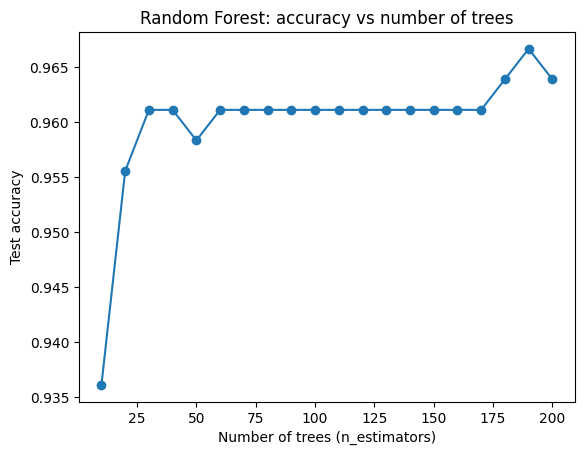

Best n_estimators on test curve: 190 acc= 0.967


In [7]:
# === Exercise 2.2 - Accuracy vs n_estimators (plot) ===
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

n_trees_list = np.linspace(10, 200, 20, dtype=int)
accs = []
for n in n_trees_list:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    accs.append(accuracy_score(y_test, rf.predict(X_test)))
plt.figure()
plt.plot(n_trees_list, accs, marker='o')
plt.xlabel('Number of trees (n_estimators)')
plt.ylabel('Test accuracy')
plt.title('Random Forest: accuracy vs number of trees')
plt.show()
best_idx = int(np.argmax(accs))
print('Best n_estimators on test curve:', int(n_trees_list[best_idx]), 'acc=', round(accs[best_idx], 3))


3. If we had picked the amount of decision trees by taking the value with the best test accuracy from the last plot, we would have *overfit* our hyperparameters to the test data. Can you see why it is a mistake to tune hyperparameters of your model by using the test data?

The test set must remain unseen. Using it for tuning leaks information and overfits to test noise; your reported accuracy becomes optimistic. Tune on a validation set or via cross-validation, then evaluate once on the test set.

4. Reshuffle and resplit the data so that it is divided in 3 parts: training (80%), validation (10%) and test (10%). Repeatedly train a model of your choosing (e.g random forest) on the training data, and evaluate it’s performance on the validation set, while tuning the hyperparameters so that the accuracy on the validation set increases. Then, finally evaluate the performance of your model on the test data. What can you say in terms of the generalization of your model?

In [8]:
# === Exercise 2.4 - Train/Val/Test split with manual tuning ===
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
X_val, X_te,  y_val, y_te  = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=123, stratify=y_tmp)

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}
best_score, best_params = -1, None
for n in param_grid['n_estimators']:
    for d in param_grid['max_depth']:
        for m in param_grid['min_samples_split']:
            clf = RandomForestClassifier(n_estimators=n, max_depth=d, min_samples_split=m, random_state=123)
            clf.fit(X_tr, y_tr)
            acc_val = accuracy_score(y_val, clf.predict(X_val))
            if acc_val > best_score:
                best_score, best_params = acc_val, {'n_estimators': n, 'max_depth': d, 'min_samples_split': m}
print('Best validation params:', best_params, 'val_acc=', round(best_score, 3))
clf_final = RandomForestClassifier(**best_params, random_state=123)
clf_final.fit(np.vstack([X_tr, X_val]), np.hstack([y_tr, y_val]))
acc_test = accuracy_score(y_te, clf_final.predict(X_te))
print('Test accuracy with tuned RF:', round(acc_test, 3))


Best validation params: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2} val_acc= 1.0
Test accuracy with tuned RF: 0.972


**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

## Exercise 3 | TPOT

The process of picking a suitable model, evaluating its performance and tuning the hyperparameters is very time consuming. A new idea in machine learning is the concept of automating this by using an optimization algorithm to find the best model in the space of models and their hyperparameters. Have a look at [TPOT](https://github.com/EpistasisLab/tpot), an automated ML solution that finds a good model and a good set of hyperparameters automatically. Try it on this data, it should outperform simple models like the ones we tried easily. Note that running the algorithm might take a while, depending on the strength of your computer. 

*Note*: In case it is running for too long, try checking if the parameters you are using when calling TPOT are reasonable, i.e. try reducing number of ‘generations’ or ‘population_size’. TPOT uses cross-validation internally, so we don’t need our own validation set.

In [9]:
# === Exercise 3 - TPOT AutoML (optional if available) ===
import importlib, time

from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
t0 = time.time()
tpot = TPOTClassifier(generations=5, population_size=30, random_state=42, max_time_mins=10)
tpot.fit(X_train, y_train)
pred = tpot.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f'TPOT test accuracy: {acc:.3f} | elapsed {time.time()-t0:.1f}s')


/Users/villafuertech/.venvs/jlab/lib/python3.12/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/villafuertech/.venvs/jlab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/villafuertech/.venvs/jlab/lib/python3.12/site-packages/tpot/tpot_estimator/estimator.py:458: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
/Users/villafuertech/.venvs/jlab/lib/python3.12/site-pack

TPOT test accuracy: 0.978 | elapsed 610.8s


**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**